In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# Force CPU:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### load existing Model:

In [6]:
from imports.models.losses import bce_dice_loss, dice_coeff
from keras.models import load_model, model_from_json

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/circle_val_dice_coeff_0.5142_sgd_lr=0.0001_momentum=0.98.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff})
model2 = load_model('../saved_models/unet/unet1024_60epochs.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff})

In [27]:
model.load_weights('../saved_models/unet/circle_val_dice_coeff_0.60796_adadelta_default.hdf5')

# 2. Visualize

### 2.1 Show Samples of trained Model:

In [7]:
train_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')
test_df = pd.read_pickle(DATA_BASE_PATH+'/test_df')

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


In [8]:
val_df.sample(2)

image_path                    mask_path  \
84  ../data/00_train_all/images/  ../data/00_train_all/masks/   
89  ../data/00_train_all/images/  ../data/00_train_all/masks/   

                       mask_cirlce_path          name dataset  \
84  ../data/00_train_all/masks_autogen/  img_1242.png    None   
89  ../data/00_train_all/masks_autogen/  img_1471.png    None   

                                             mask_rle  \
84  1690 120 1833 1 1860 4 3226 120 3365 9 3393 11...   
89  1043848 3 1045381 9 1046915 15 1048450 18 1049...   

                                      mask_circle_rle  \
84  1024 1098 5629 1104 10237 1107 14842 1113 1944...   
89  2878159 81 2882740 135 2887330 171 2891923 201...   

                                                roots  \
84  [[590.042144917463, 100.37468354430383], [469....   
89           [[935.1495395308428, 777.0390683544305]]   

                                              splines  
84  [[[1176.7886290182448, 423.7973357882625], [12...  
89  [[[931.3782658557776, 742.9502968929804], [917...

In [9]:
vis_params = {'df':val_df,
              'model':model2}

visualize = Visualize(**vis_params)

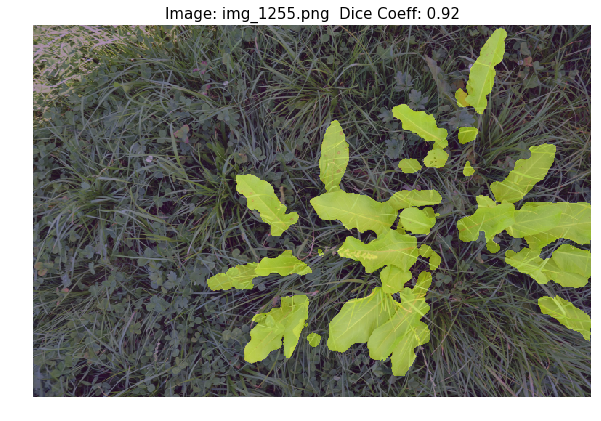

In [46]:
visualize.show_single(index='1255',mode='image_prediction')

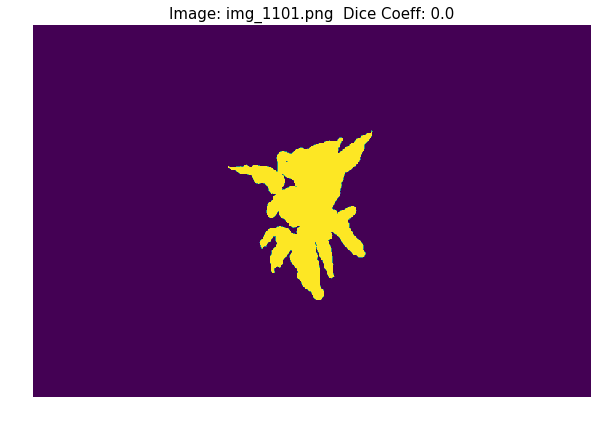

In [47]:
visualize.show_single(index='random',mode='mask')

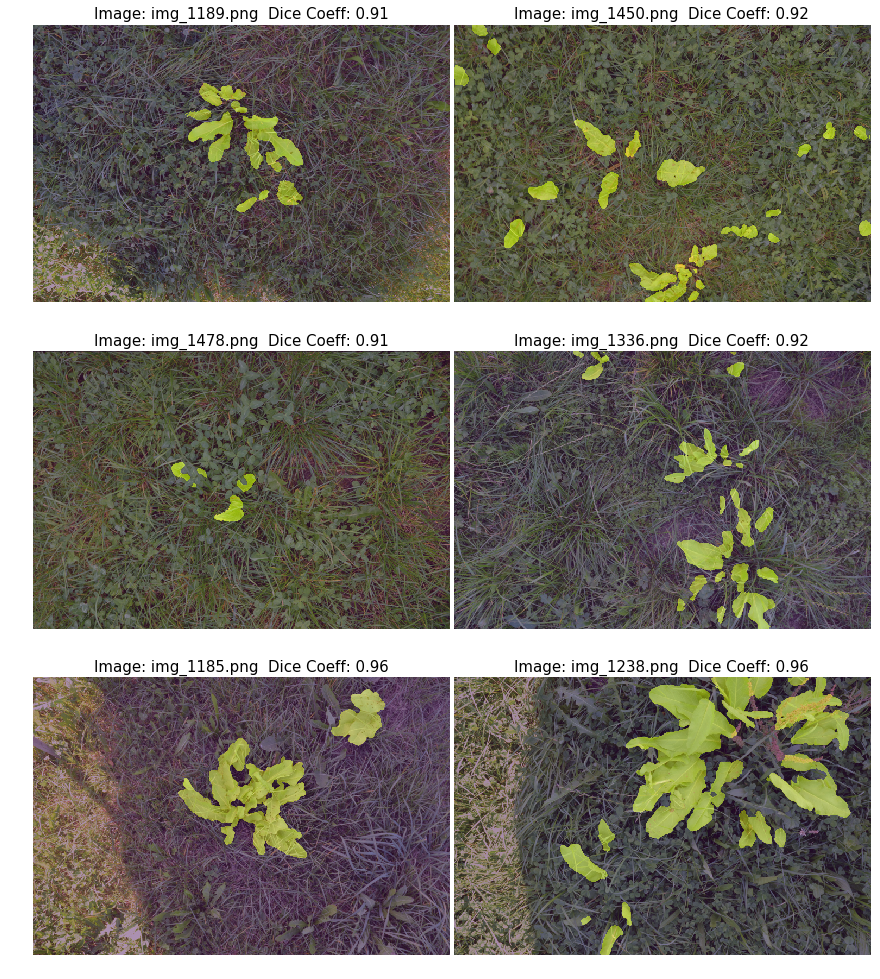

In [48]:
visualize.show_matrix(index='random',mode='image_prediction',rows=3)

### Segment the predicted Masks using watershed-segmentation:

In [49]:
im = visualize.get_image(1255)
pred = visualize.get_prediction(1255)

Text(0.5,1,'Separated objects')

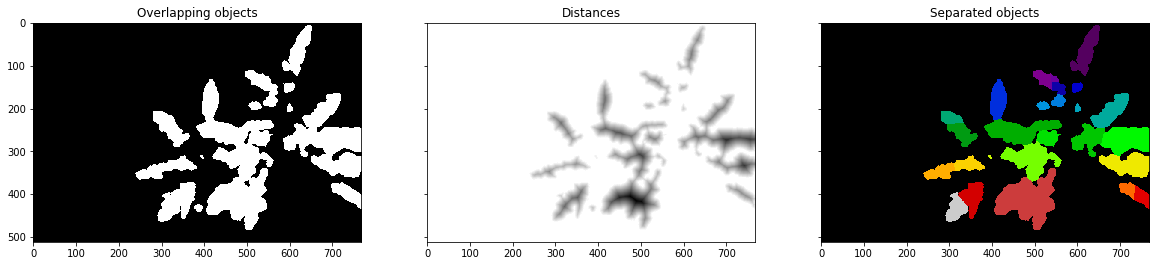

In [50]:
# http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html

def watershed_segmentation(prediction_image,threshold=0.90,footprint_size=(40,40)):
    from scipy import ndimage as ndi
    from skimage.morphology import watershed
    from skimage.feature import peak_local_max
    from skimage.draw import circle
    circle_img = np.zeros(footprint_size, dtype=np.uint8)
    rr, cc = circle(footprint_size[0]/2, footprint_size[1]/2,min(footprint_size)/2-2)
    circle_img[rr, cc] = 1
    
    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    pred_logical = prediction_image>threshold
    distance = ndi.distance_transform_edt(pred_logical)
    local_maxi = peak_local_max(distance, indices=False, footprint=circle_img, labels=pred_logical)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=pred_logical)
    
    return distance, labels

distance, labels = watershed_segmentation(pred,footprint_size=(60,60))

fig, axes = plt.subplots(ncols=3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(pred, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

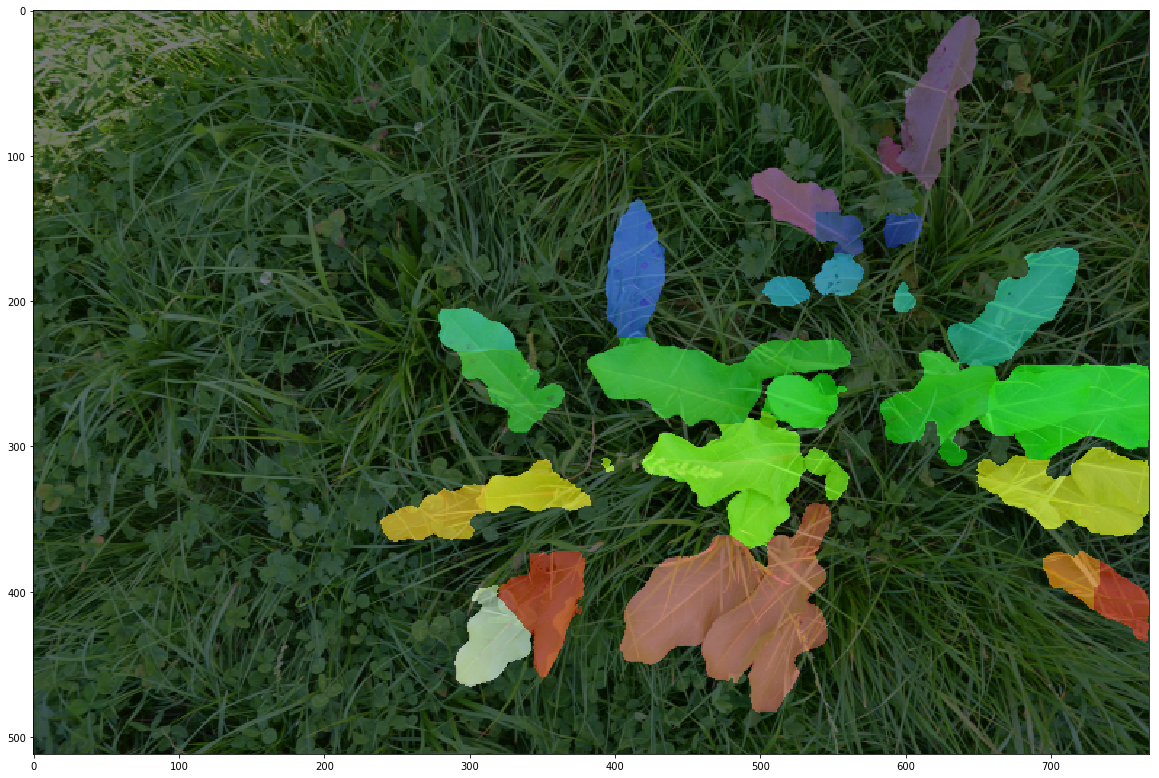

In [51]:
plt.figure(figsize=(20,20))
imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
imshow(im,alpha=0.5)

In [53]:
val_df.sample(1)

image_path                    mask_path  \
90  ../data/00_train_all/images/  ../data/00_train_all/masks/   

                       mask_cirlce_path          name dataset  \
90  ../data/00_train_all/masks_autogen/  img_1199.png    None   

                                             mask_rle  \
90  1843 25 3378 26 4911 30 6445 32 7980 34 9515 3...   

                                      mask_circle_rle  \
90  646111 81 650692 135 655282 171 659875 201 664...   

                                                roots  \
90  [[945.393987837, 421.319232221], [926.23958297...   

                                              splines  
90  [[[821.195865856, 385.627205524], [730.6069185...

In [10]:
vis_params = {'df':val_df,
              'model':model}

visualize1 = Visualize(**vis_params)

vis_params = {'df':val_df,
              'model':model2}

visualize2 = Visualize(**vis_params)

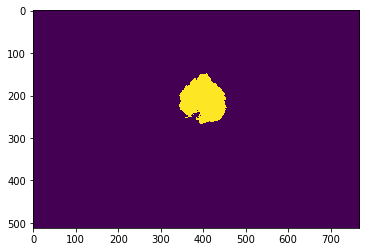

In [11]:
#1493
#1366
index = 1303
pred = visualize1.get_prediction(index=index)
pred2 = visualize2.get_prediction(index=index)
img = visualize1.get_image(index=index)
imshow(pred)

In [12]:
import skimage.measure
mask = pred > 0.5
labels = skimage.measure.label(mask)
print(labels.shape, labels.dtype)
print("Unique values in labels:", np.unique(labels))

(512, 768) int64
Unique values in labels: [0 1]


In [13]:
import ipywidgets as widgets
@widgets.interact(label = list(np.unique(labels)))
def f(label):
    print(f"The connected component with label {label} contains {np.sum(labels == label)} pixels")
    plt.imshow(labels == label)

interactive(children=(Dropdown(description='label', options=(0, 1), value=0), Output()), _dom_classes=('widget…

In [14]:
regions = skimage.measure.regionprops(labels)
large_regions = [r for r in regions if r.area > 2000]
print(f"There are {len(large_regions)} large regions")
regions[0]

There are 1 large regions


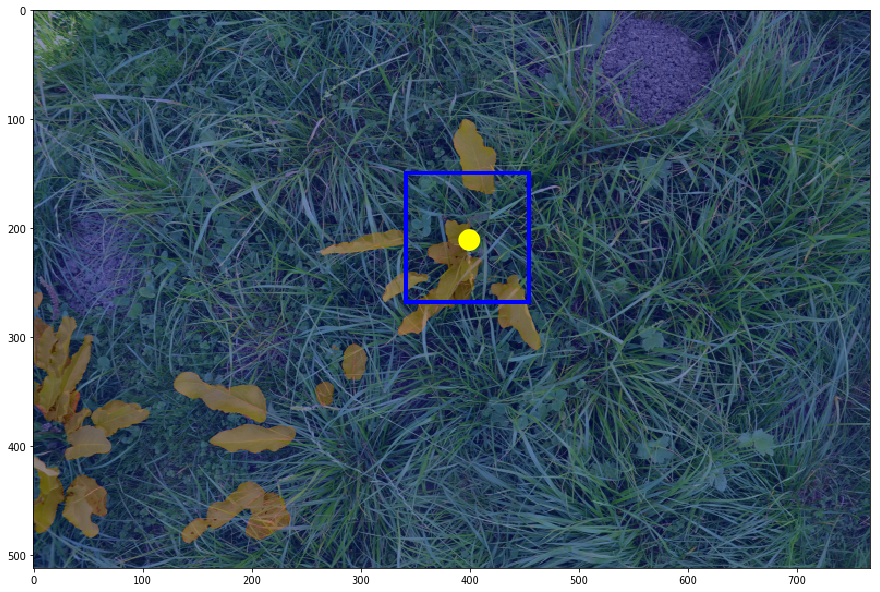

In [15]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img, cmap="gray")
ax.imshow(pred2,cmap='jet',alpha=0.4)
rects = []
circs = []
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    (c_row,c_col) = r.centroid
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                            linewidth=4,edgecolor='b',facecolor='None')
    circ = patches.Circle((c_col,c_row),10,facecolor='yellow')
    ax.add_patch(rect)
    ax.add_patch(circ)
    rects.append(rect)
    circs.append(circ)

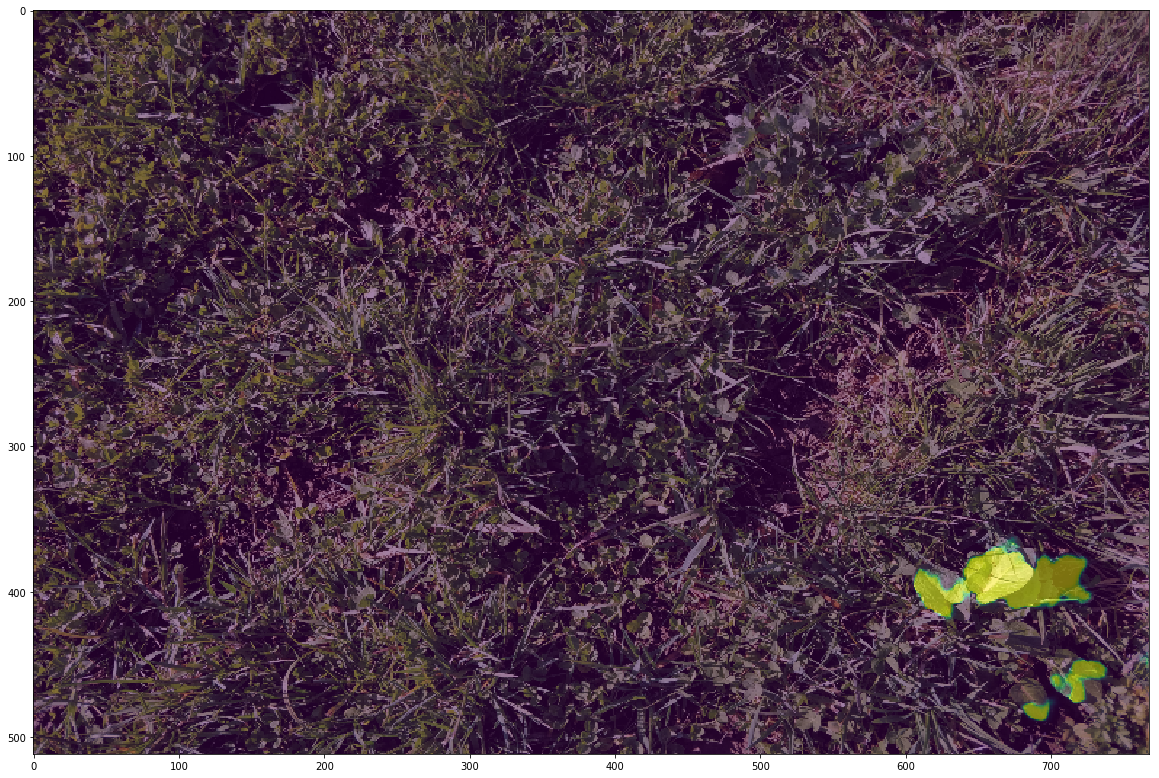

In [74]:
testim = imread(DATA_BASE_PATH+'/tmp/a.jpg')
testim = resize(testim,(SHAPE[0],SHAPE[1])).reshape(*SHAPE,3)
testpred = model2.predict(testim.reshape(1,*SHAPE,3))
plt.figure(figsize=(20,20))
imshow(testim)
imshow(testpred.reshape(*SHAPE),alpha=0.5)

In [149]:
def overlap(r1, r2):
    '''Overlapping rectangles overlap both horizontally & vertically
    '''
    r1_left = r1.get_x()
    r1_right = r1.get_x()+r1.get_width()
    r2_left = r2.get_x()
    r2_right = r2.get_x()+r2.get_width()
    r1_bottom = r1.get_y()+r1.get_height()
    r1_top = r1.get_y()
    r2_bottom = r2.get_y()+r2.get_height()
    r2_top = r2.get_y()
    
    # Overlap horizontally OR vertically
    
    return range_overlap(r1_left, r1_right, r2_left, r2_right) or range_overlap(r1_bottom,r1_top,r2_bottom,r2_top)
    #return range_overlap(r1.left, r1.right, r2.left, r2.right) and range_overlap(r1.bottom, r1.top, r2.bottom, r2.top)

def range_overlap(a_min, a_max, b_min, b_max):
    '''Neither range is completely greater than the other
    '''
    return not ((a_min > b_max) or (b_min > a_max))

def combine_rects(r1,r2):
    x = min(r1.get_x(),r2.get_x())
    y = min(r1.get_y(),r2.get_y())
    width = max(r1.get_width(),r2.get_width())
    height = max(r1.get_height(),r2.get_height())
    rnew = patches.Rectangle((x,y),width,height,linewidth=4,edgecolor='g',facecolor='none')
    return rnew

In [33]:
rectsnew = []
for i in range(4):
    for j in range(4):
        if i != j:
            if overlap(rects[j],rects[i]) == True:
                rectsnew.append(combine_rects(rects[j],rects[i]))
            print(overlap(rects[j],rects[i]))

True


IndexError: list index out of range

In [34]:
for i in rectsnew:
    print(i)

Rectangle(xy=(298, 114), width=336, height=362, angle=0)


In [35]:
n = 4
bbox = np.zeros((n,4))
for i in range(n):
    bbox[i,0] = rects[i].get_x()
    bbox[i,1] = rects[i].get_y()
    bbox[i,2] = rects[i].get_x() + rects[i].get_width()
    bbox[i,3] = rects[i].get_y() + rects[i].get_height()

IndexError: list index out of range

In [36]:
bbox

array([[298., 114., 634., 476.],
       [335., 136., 409., 197.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.]])

#### Eigenvector Test:

In [37]:
#Eigenvector Test:
tmp = pred>0.9
y, x = np.nonzero(tmp)
x = x - np.mean(x)
y = y - np.mean(y)
coords = np.vstack([x, y])
cov = np.cov(coords)
evals, evecs = np.linalg.eig(cov)
sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]


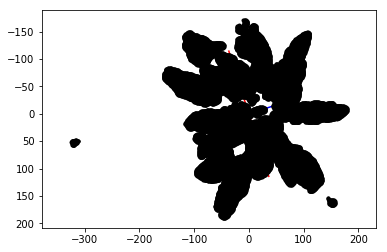

In [38]:
scale = 60
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.plot(x, y, 'k.')
plt.axis('equal')
plt.gca().invert_yaxis()  # Match the image system with origin at top left
plt.show()